In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
import time

def rooted_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) **2)**0.5

class RandomForestMSE:
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.estimators = []
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        X_val : numpy ndarray
            Array of size n_val_objects, n_features
        y_val : numpy ndarray
            Array of size n_val_objects
        """
        feature_subsample_size = X.shape[1] // 3 if self.feature_subsample_size is None else self.feature_subsample_size
        train_loss = []
        test_loss = []
        times = []
        train_sum = 0.
        test_sum = 0.
        start = time.perf_counter()
        for _ in range(self.n_estimators):
            inds = np.random.choice(len(y), len(y))
            self.estimators.append(DecisionTreeRegressor(
                max_depth=self.max_depth, max_features=feature_subsample_size, **self.trees_parameters).fit(X[inds], y[inds])
            )
            train_sum += self.estimators[-1].predict(X)
            train_loss.append(rooted_mse(train_sum / len(self.estimators), y))
            times.append(time.perf_counter() - start)
            if X_val is not None:
                test_sum += self.estimators[-1].predict(X_val)
                test_loss.append(rooted_mse(test_sum / len(self.estimators), y_val))
        if X_val is not None:
            return train_loss, test_loss, times
        else:
            return train_loss, times
        

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        return np.array([tree.predict(X) for tree in self.estimators]).mean(0)



class GradientBoostingMSE:
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        learning_rate : float
            Use alpha * learning_rate instead of alpha
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        self.estimators = []
        self.weights = []
        self.indices = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        """
        feature_subsample_size = X.shape[1] // 3 if self.feature_subsample_size is None else self.feature_subsample_size
        train_loss = []
        test_loss = []
        times = []
        test_sum = 0
        value = 0
        start = time.perf_counter()
        for _ in range(self.n_estimators):
            gradients = 2*(y - value)
            self.estimators.append(
                DecisionTreeRegressor(
                    max_depth=self.max_depth,
                    max_features=feature_subsample_size,
                    **self.trees_parameters
                ).fit(X, gradients)
            )
            pred = self.estimators[-1].predict(X)
            a = minimize_scalar(lambda x: rooted_mse(value + x*pred, y)).x
            self.weights.append(self.learning_rate * a)
            value += self.weights[-1] * self.estimators[-1].predict(X)
            times.append(time.perf_counter() - start)
            train_loss.append(rooted_mse(value, y))
            if X_val is not None:
                test_sum += self.weights[-1] * self.estimators[-1].predict(X_val)
                test_loss.append(rooted_mse(test_sum, y_val))
        if X_val is not None:
            return train_loss, test_loss, times
        else:
            return train_loss, times

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        result = 0.
        for weight, tree in zip(self.weights,self.estimators):
            result += weight * tree.predict(X)
        return result

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
import time

In [3]:
data = pd.read_csv('kc_house_data.csv', index_col=0)
target = data.price.values
data = data.drop('price', axis=1)

In [4]:
data["date"].apply(lambda x: x[8:]).unique()

array(['T000000'], dtype=object)

In [5]:
data["date"] = data["date"].apply(lambda x: x[:8])

In [6]:
data["year"] = data["date"].apply(lambda x: int(x[:4]))
data["month"] = data["date"].apply(lambda x: int(x[4:6]))
data["day"] = data["date"].apply(lambda x: int(x[6:]))
data = data.drop("date", axis=1)

In [7]:
data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,21
6600060120,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,2014,0,98146,47.5107,-122.362,1830,7200,2015,2,23
1523300141,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,2009,0,98144,47.5944,-122.299,1020,2007,2014,6,23


In [8]:
X = data.values
X

array([[3.000e+00, 1.000e+00, 1.180e+03, ..., 2.014e+03, 1.000e+01,
        1.300e+01],
       [3.000e+00, 2.250e+00, 2.570e+03, ..., 2.014e+03, 1.200e+01,
        9.000e+00],
       [2.000e+00, 1.000e+00, 7.700e+02, ..., 2.015e+03, 2.000e+00,
        2.500e+01],
       ...,
       [2.000e+00, 7.500e-01, 1.020e+03, ..., 2.014e+03, 6.000e+00,
        2.300e+01],
       [3.000e+00, 2.500e+00, 1.600e+03, ..., 2.015e+03, 1.000e+00,
        1.600e+01],
       [2.000e+00, 7.500e-01, 1.020e+03, ..., 2.014e+03, 1.000e+01,
        1.500e+01]])

In [9]:
np.random.seed(0)
inds = set(np.random.choice(X.shape[0], 3*X.shape[0]//10, replace=False))

In [10]:
X_train, X_test = X[list(set(np.arange(X.shape[0])) - inds)], X[list(inds)]
y_train, y_test = target[list(set(np.arange(X.shape[0])) - inds)], target[list(inds)]

In [11]:
X_train.shape

(15130, 21)

In [12]:
num_trees = np.array([1, 5, 10, 50, 100, 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000])

In [13]:
res1_train = []
res1_test = []
res1_times = []

In [14]:
for i in num_trees:
    reg = RandomForestMSE(n_estimators=i)
    a, b, c = reg.fit(X_train, y_train, X_test, y_test)
    res1_train.append(a)
    res1_test.append(b)
    res1_times.append(c)

In [15]:
list(map(lambda x: x[-1], res1_test))

[210485.2473748903,
 154990.24081037752,
 147260.83936690222,
 133636.7532080572,
 132622.58668381433,
 132408.85790115225,
 130643.96698527486,
 130887.59680096149,
 130780.82538659721,
 131221.2677810648,
 131190.64103134995,
 131075.18185975493,
 130692.94668339546,
 131202.83043598972,
 131343.41490640608]

In [16]:
res1_last = list(map(lambda x: x[-1], res1_test))

In [17]:
num_trees[np.argmin(res1_last)]

400

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

%config InlineBackend.figure_format = 'svg'

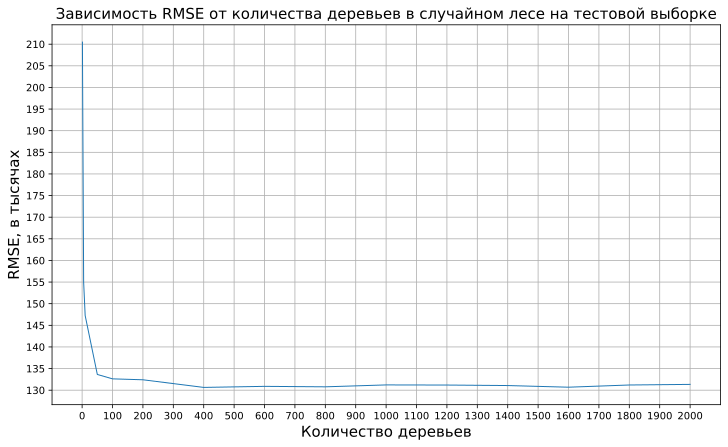

In [20]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от количества деревьев в случайном лесе на тестовой выборке", fontsize=15)
plt.xlabel("Количество деревьев", fontsize=15)
plt.ylabel("RMSE, в тысячах", fontsize=15)
    
pos = np.arange(0, 2100, 100)
ax.set_xticks(pos)
ax.set_yticks(np.arange(110, 300, 5))
        
lw = 1
plt.plot(num_trees, np.array(list(map(lambda x: x[-1], res1_test)))/1000, linewidth=lw)
plt.grid()
plt.show()
fig.savefig("1.1.pdf", bbox_inches = 'tight')

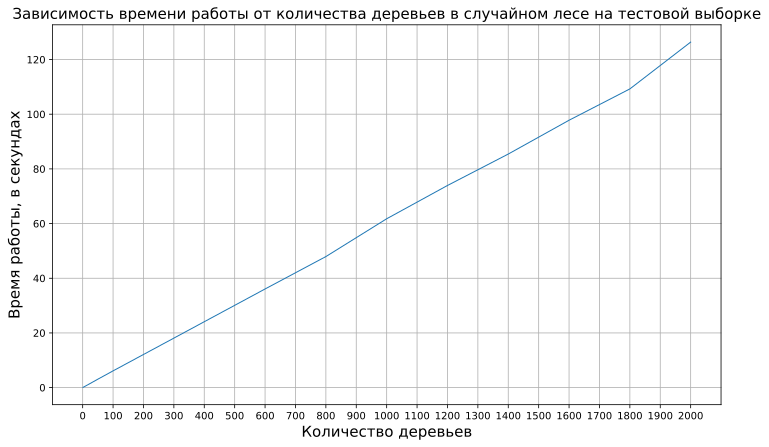

In [21]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость времени работы от количества деревьев в случайном лесе на тестовой выборке", fontsize=15)
plt.xlabel("Количество деревьев", fontsize=15)
plt.ylabel("Время работы, в секундах", fontsize=15)
    
pos = np.arange(0, 2100, 100)
ax.set_xticks(pos)
#ax.set_yticks(np.arange(140, 300, 5))
        
lw = 1
plt.plot(num_trees, np.array(list(map(lambda x: x[-1], res1_times))), linewidth=lw)
plt.grid()
plt.show()
fig.savefig("1.2.pdf", bbox_inches = 'tight')

In [22]:
num_cats = np.arange(1, 22, 2)

In [23]:
res2_train = []
res2_test = []
res2_times = []

In [24]:
for i in num_cats:
    reg = RandomForestMSE(n_estimators=600, feature_subsample_size=i)
    a, b, c = reg.fit(X_train, y_train, X_test, y_test)
    res2_train.append(a)
    res2_test.append(b)
    res2_times.append(c)

In [25]:
list(map(lambda x: x[-1], res2_test))

[169340.2018011772,
 143017.60014126103,
 134469.58894922945,
 130506.26991283405,
 129461.64100134121,
 127982.76172867307,
 127473.58672940491,
 127085.80656507795,
 126472.21718097219,
 126495.51334524954,
 126457.65779760202]

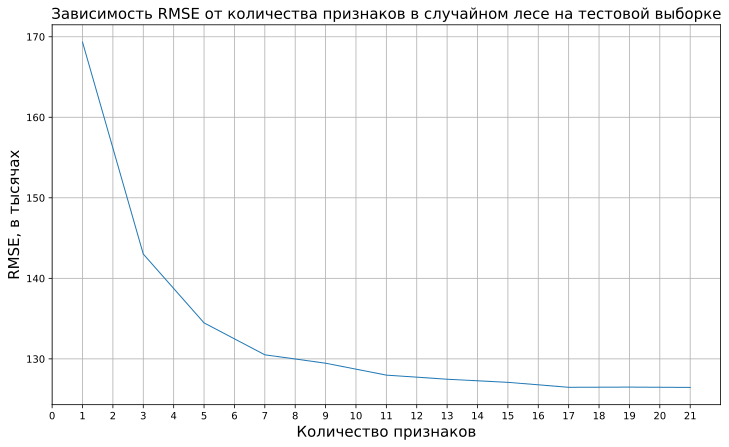

In [26]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от количества признаков в случайном лесе на тестовой выборке", fontsize=15)
plt.xlabel("Количество признаков", fontsize=15)
plt.ylabel("RMSE, в тысячах", fontsize=15)
    
#pos = np.arange(0, 2100, 100)
ax.set_xticks(np.arange(0, 22))
#ax.set_yticks(np.arange(140, 260, 5))
        
lw = 1
plt.plot(num_cats, np.array(list(map(lambda x: x[-1], res2_test)))/1000, linewidth=lw)
plt.grid()
plt.show()
fig.savefig("2.1.pdf", bbox_inches = 'tight')

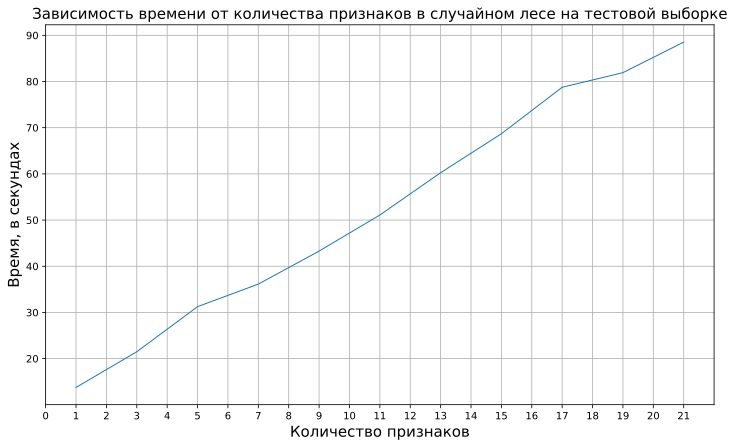

In [27]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость времени от количества признаков в случайном лесе на тестовой выборке", fontsize=15)
plt.xlabel("Количество признаков", fontsize=15)
plt.ylabel("Время, в секундах", fontsize=15)
    
#pos = np.arange(0, 2100, 100)
ax.set_xticks(np.arange(0, 22))
#ax.set_yticks(np.arange(140, 260, 5))
        
lw = 1
plt.plot(num_cats, np.array(list(map(lambda x: x[-1], res2_times))), linewidth=lw)
plt.grid()
plt.show()
fig.savefig("2.2.pdf", bbox_inches = 'tight')

In [28]:
deepness = np.arange(1, 50, 4)

In [29]:
res3_train = []
res3_test = []
res3_times = []

In [30]:
for i in deepness:
    reg = RandomForestMSE(n_estimators=600, feature_subsample_size=17, max_depth=i)
    a, b, c = reg.fit(X_train, y_train, X_test, y_test)
    res3_train.append(a)
    res3_test.append(b)
    res3_times.append(c)

In [31]:
list(map(lambda x: x[-1], res3_test))

[285018.8714595135,
 168930.4211680698,
 136307.88231590562,
 128806.51061603024,
 126419.38309487893,
 126824.23896697177,
 127084.46400908186,
 127653.021766317,
 127196.24415121108,
 126355.75512261115,
 126931.72744657224,
 126830.91159463172,
 127171.3316226791]

In [32]:
deepness[np.argmin(list(map(lambda x: x[-1], res3_test)))]

37

In [33]:
reg = RandomForestMSE(n_estimators=600, feature_subsample_size=17)
a, b, c = reg.fit(X_train, y_train, X_test, y_test)

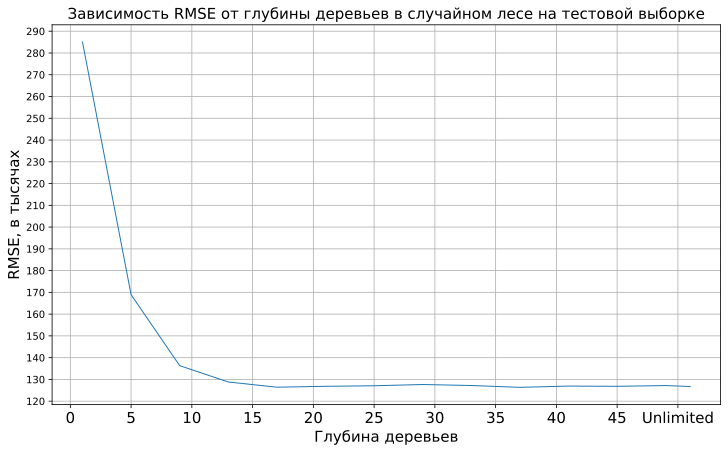

In [35]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от глубины деревьев в случайном лесе на тестовой выборке", fontsize=15)
plt.xlabel("Глубина деревьев", fontsize=15)
plt.ylabel("RMSE, в тысячах", fontsize=15)
    
pos = np.arange(0, 55, 5)
ax.set_xticks(pos)
ax.set_xticklabels(list(map(str, pos[:-1])) + ["Unlimited"], fontsize=15)
ax.set_yticks(np.arange(110, 300, 10))
        
lw = 1
plt.plot(list(deepness) + [51], np.array(list(map(lambda x: x[-1], res3_test)) + [b[-1]])/1000, linewidth=lw)
plt.grid()
plt.show()
fig.savefig("3.1.pdf", bbox_inches = 'tight')

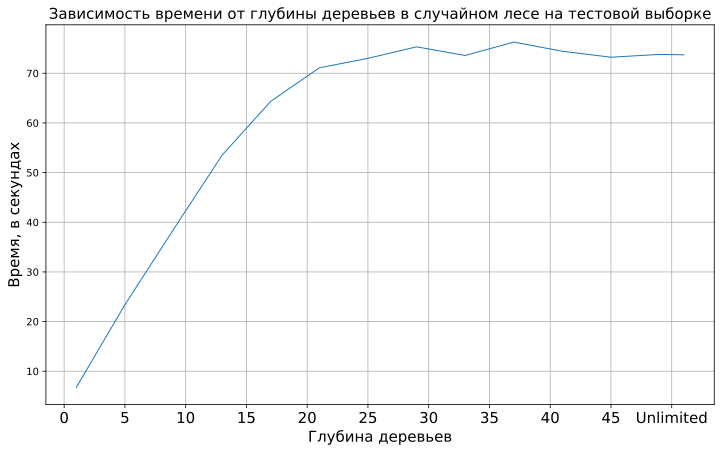

In [36]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость времени от глубины деревьев в случайном лесе на тестовой выборке", fontsize=15)
plt.xlabel("Глубина деревьев", fontsize=15)
plt.ylabel("Время, в секундах", fontsize=15)
    
pos = np.arange(0, 55, 5)
ax.set_xticks(pos)
ax.set_xticklabels(list(map(str, pos[:-1])) + ["Unlimited"], fontsize=15)
#ax.set_yticks(np.arange(130, 300, 10))
        
lw = 1
plt.plot(list(deepness) + [51], np.array(list(map(lambda x: x[-1], res3_times)) + [c[-1]]), linewidth=lw)
plt.grid()
plt.show()
fig.savefig("3.2.pdf", bbox_inches = 'tight')

In [37]:
res4_train = []
res4_test = []
res4_times = []

In [38]:
for i in num_trees:
    reg = GradientBoostingMSE(n_estimators=i)
    a, b, c = reg.fit(X_train, y_train, X_test, y_test)
    res4_train.append(a)
    res4_test.append(b)
    res4_times.append(c)

In [39]:
list(map(lambda x: x[-1], res4_test))

[596715.3149752978,
 420338.9254488091,
 289004.50859497784,
 131672.77673186953,
 123885.84848745189,
 118808.11010155783,
 116133.03738382837,
 117697.50609301726,
 118570.9970579527,
 115548.85318097773,
 114667.24874286147,
 113519.93702191074,
 116462.7780197687,
 111292.39192422191,
 115217.65812207882]

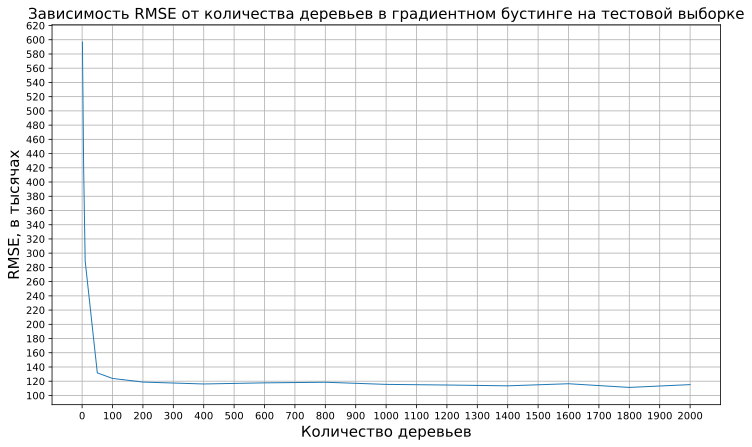

In [43]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от количества деревьев в градиентном бустинге на тестовой выборке", fontsize=15)
plt.xlabel("Количество деревьев", fontsize=15)
plt.ylabel("RMSE, в тысячах", fontsize=15)
    
pos = np.arange(0, 2100, 100)
ax.set_xticks(pos)
ax.set_yticks(np.arange(100, 700, 20))
        
lw = 1
plt.plot(num_trees, np.array(list(map(lambda x: x[-1], res4_test)))/1000, linewidth=lw)
plt.grid()
plt.show()
fig.savefig("4.1.pdf", bbox_inches = 'tight')

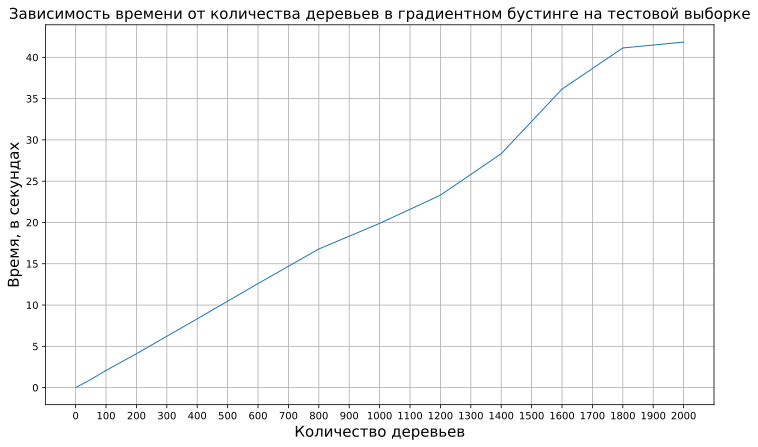

In [44]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость времени от количества деревьев в градиентном бустинге на тестовой выборке", fontsize=15)
plt.xlabel("Количество деревьев", fontsize=15)
plt.ylabel("Время, в секундах", fontsize=15)
    
pos = np.arange(0, 2100, 100)
ax.set_xticks(pos)
ax.set_yticks(np.arange(0, 600, 5))
        
lw = 1
plt.plot(num_trees, np.array(list(map(lambda x: x[-1], res4_times))), linewidth=lw)
plt.grid()
plt.show()
fig.savefig("4.2.pdf", bbox_inches = 'tight')

In [53]:
num_cats = np.arange(1, 22, 1)

In [54]:
res5_train = []
res5_test = []
res5_times = []

In [55]:
for i in num_cats:
    reg = GradientBoostingMSE(n_estimators=1000, feature_subsample_size=i)
    a, b, c = reg.fit(X_train, y_train, X_test, y_test)
    res5_train.append(a)
    res5_test.append(b)
    res5_times.append(c)

In [56]:
list(map(lambda x: x[-1], res5_test))

[131720.29534335757,
 122602.2577259711,
 119151.0020504211,
 116066.55603454389,
 113840.56093585445,
 115491.86555485908,
 119467.43701755904,
 113866.98748113784,
 113753.01158268018,
 112066.15488653436,
 111130.849409353,
 117089.61934382601,
 111375.94190346498,
 115029.03831307586,
 113932.8770138633,
 114220.0368914997,
 115448.31940083488,
 114100.35894850327,
 115791.10884790315,
 114712.78818329534,
 115191.93214861832]

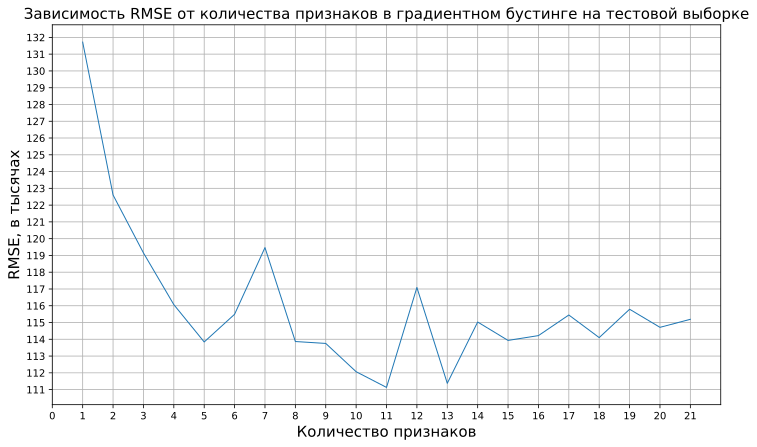

In [57]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от количества признаков в градиентном бустинге на тестовой выборке", fontsize=15)
plt.xlabel("Количество признаков", fontsize=15)
plt.ylabel("RMSE, в тысячах", fontsize=15)
    
#pos = np.arange(0, 2100, 100)
ax.set_xticks(np.arange(0, 22))
ax.set_yticks(np.arange(110, 260, 1))
        
lw = 1
plt.plot(num_cats, np.array(list(map(lambda x: x[-1], res5_test)))/1000, linewidth=lw)
plt.grid()
plt.show()
fig.savefig("5.1.pdf", bbox_inches = 'tight')

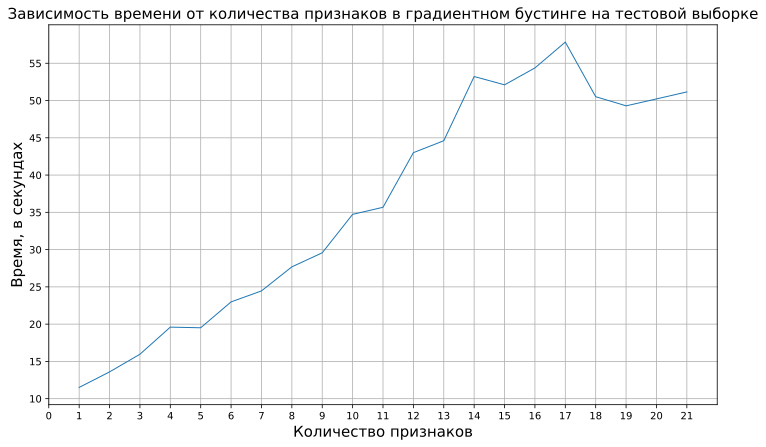

In [58]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость времени от количества признаков в градиентном бустинге на тестовой выборке", fontsize=15)
plt.xlabel("Количество признаков", fontsize=15)
plt.ylabel("Время, в секундах", fontsize=15)
    
ax.set_xticks(np.arange(0, 22))
ax.set_yticks(np.arange(0, 60, 5))
        
lw = 1
plt.plot(num_cats, np.array(list(map(lambda x: x[-1], res5_times))), linewidth=lw)
plt.grid()
plt.show()
fig.savefig("5.2.pdf", bbox_inches = 'tight')

In [62]:
deepness = np.arange(1, 50, 2)

In [63]:
res6_train = []
res6_test = []
res6_times = []

In [64]:
for i in deepness:
    reg = GradientBoostingMSE(n_estimators=1000, feature_subsample_size=11, max_depth=i)
    a, b, c = reg.fit(X_train, y_train, X_test, y_test)
    res6_train.append(a)
    res6_test.append(b)
    res6_times.append(c)

In [65]:
list(map(lambda x: x[-1], res6_test))

[156174.28704675336,
 114660.19774575766,
 111881.07477650003,
 116432.94628875934,
 120687.36187517688,
 122752.33430841932,
 126167.39112650258,
 129286.72469849228,
 135542.33667938682,
 130881.93091907418,
 131819.34942795933,
 132001.27537873582,
 130586.14414523057,
 135652.50686376943,
 130342.51337256072,
 134167.69646300934,
 130087.7580880369,
 130586.90779984536,
 129214.05475733001,
 129520.06017887486,
 132190.61303727387,
 136149.83658470787,
 131588.64510728535,
 127210.33922247912,
 134937.63859249724]

In [66]:
reg = GradientBoostingMSE(n_estimators=1000, feature_subsample_size=11)
a, b, c = reg.fit(X_train, y_train, X_test, y_test)

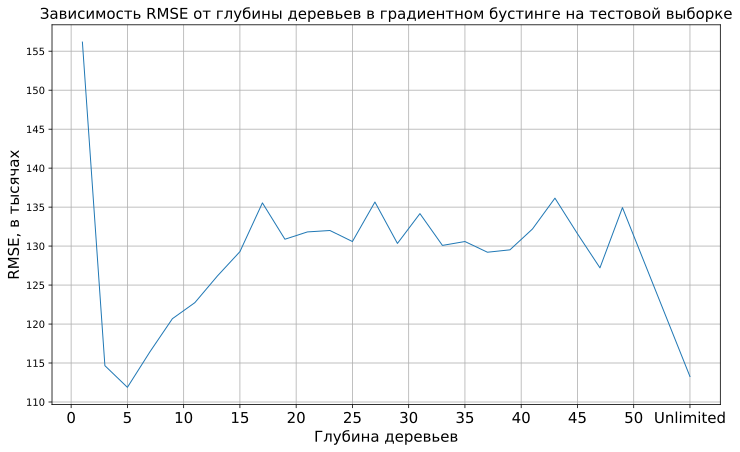

In [67]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от глубины деревьев в градиентном бустинге на тестовой выборке", fontsize=15)
plt.xlabel("Глубина деревьев", fontsize=15)
plt.ylabel("RMSE, в тысячах", fontsize=15)
    
pos = np.arange(0, 56, 5)
ax.set_xticks(pos)
ax.set_yticks(np.arange(110, 260, 5))
ax.set_xticklabels(list(map(str, pos[:-1])) + ["Unlimited"], fontsize=15)
        
lw = 1
plt.plot(list(deepness) + [55], np.array(list(map(lambda x: x[-1], res6_test)) + [b[-1]])/1000, linewidth=lw)
plt.grid()
plt.show()
fig.savefig("6.1.pdf", bbox_inches = 'tight')

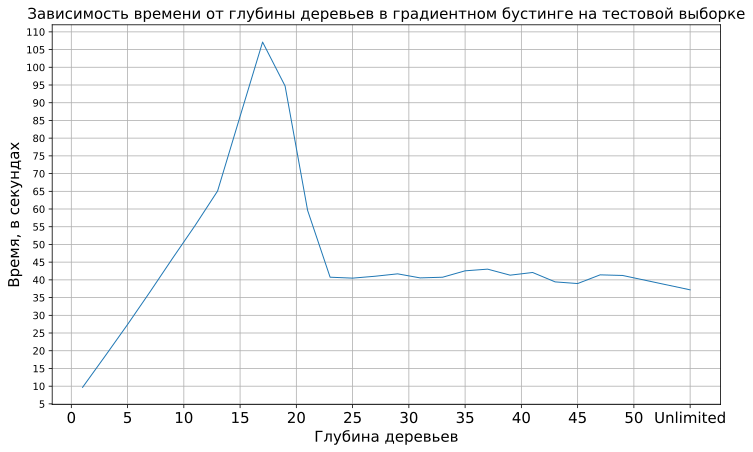

In [68]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость времени от глубины деревьев в градиентном бустинге на тестовой выборке", fontsize=15)
plt.xlabel("Глубина деревьев", fontsize=15)
plt.ylabel("Время, в секундах", fontsize=15)
    
pos = np.arange(0, 56, 5)
ax.set_xticks(pos)
ax.set_yticks(np.arange(0, 260, 5))
ax.set_xticklabels(list(map(str, pos[:-1])) + ["Unlimited"], fontsize=15)
        
lw = 1
plt.plot(list(deepness) + [55], np.array(list(map(lambda x: x[-1], res6_times)) + [c[-1]]), linewidth=lw)
plt.grid()
plt.show()
fig.savefig("6.2.pdf", bbox_inches = 'tight')

In [69]:
learning_rates = np.logspace(-7, 0, 8)

In [70]:
res7_train = []
res7_test = []
res7_times = []

In [71]:
for i in learning_rates:
    reg = GradientBoostingMSE(n_estimators=1000, feature_subsample_size=11, max_depth=5, learning_rate=i)
    a, b, c = reg.fit(X_train, y_train, X_test, y_test)
    res7_train.append(a)
    res7_test.append(b)
    res7_times.append(c)

In [72]:
list(map(lambda x: x[-1], res7_test))

[653960.650078004,
 653434.5168998787,
 648200.9578545778,
 598433.1068147896,
 292381.17215908685,
 119332.83969008653,
 110400.02110834052,
 180785.1906416448]

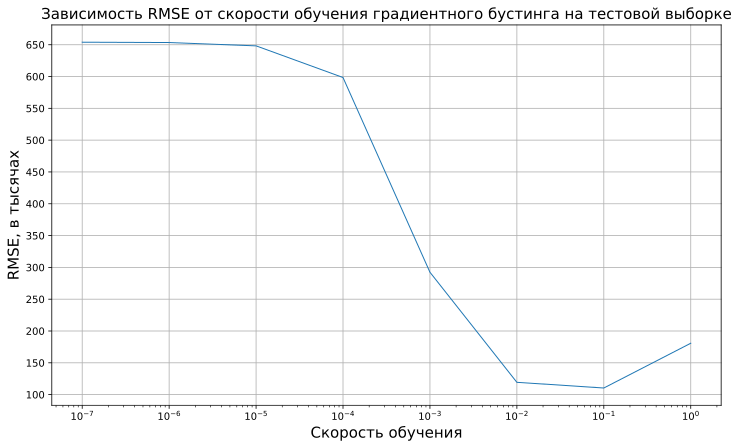

In [73]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от скорости обучения градиентного бустинга на тестовой выборке", fontsize=15)
plt.xlabel("Скорость обучения", fontsize=15)
plt.ylabel("RMSE, в тысячах", fontsize=15)

plt.xscale("log")
#pos = np.arange(0, 50, 5)
#ax.set_xticks(pos)
ax.set_yticks(np.arange(100, 700, 50))
        
lw = 1
plt.plot(learning_rates, np.array(list(map(lambda x: x[-1], res7_test)))/1000, linewidth=lw)
plt.grid()
plt.show()
fig.savefig("7.1.pdf", bbox_inches = 'tight')

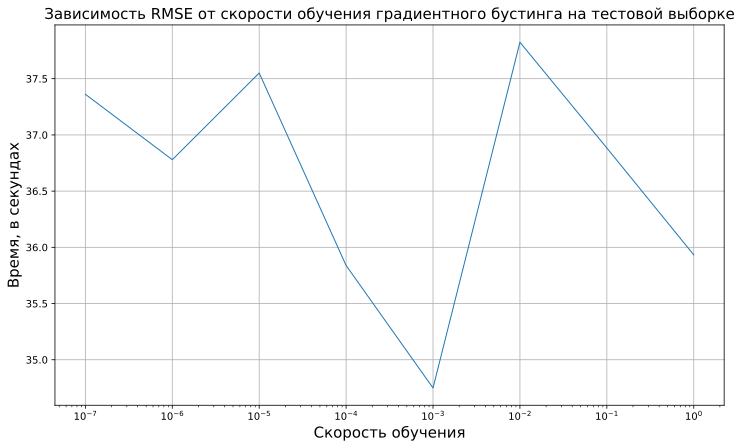

In [74]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зависимость RMSE от скорости обучения градиентного бустинга на тестовой выборке", fontsize=15)
plt.xlabel("Скорость обучения", fontsize=15)
plt.ylabel("Время, в секундах", fontsize=15)

plt.xscale("log")
#pos = np.arange(0, 50, 5)
#ax.set_xticks(pos)
#ax.set_yticks(np.arange(100, 700, 50))
        
lw = 1
plt.plot(learning_rates, np.array(list(map(lambda x: x[-1], res7_times))), linewidth=lw)
plt.grid()
plt.show()
fig.savefig("7.2.pdf", bbox_inches = 'tight')